In [8]:
import json
import os 
import scipy.io
import random
from sklearn.preprocessing import MinMaxScaler # normalize the x,y coordinates
import networkx as nx # for graph
import matplotlib.pyplot as plt
import numpy as np

Define the nodes for the poses

In [9]:
graph = dict() # initialize graph

points = []
# read the landmarks.m file
with open('landmarks\horse\landmarks.m', 'r') as f:
    for i in f:
        split_result = i.split(' = ')
        if len(split_result) >= 2:
            # print(split_result[1].split(';')[0])
            points.append(split_result[1].split(';')[0].split("'")[1])

# add points to graph
graph['chin'] = ['leftEye', 'rightEye', 'neck']
graph['rightEye'] = ['chin', 'leftEye', 'neck']
graph['leftEye'] = ['chin', 'rightEye', 'neck']
graph['neck'] = ['chin', 'leftEye', 'rightEye', 'leftShoulder', 'rightShoulder']
graph['leftShoulder'] = ['neck', 'frontLeftHip', 'tailStart']
graph['rightShoulder'] = ['neck', 'frontRightHip', 'tailStart']
graph['frontLeftHip'] = ['leftShoulder', 'frontLeftKnee']
graph['frontRightHip'] = ['rightShoulder', 'frontRightKnee']
graph['frontLeftKnee'] = ['frontLeftHip', 'frontLeftHoof']
graph['frontRightKnee'] = ['frontRightHip', 'frontRightHoof']
graph['frontLeftHoof'] = ['frontLeftKnee']
graph['frontRightHoof'] = ['frontRightKnee']
graph['tailStart'] = ['leftShoulder', 'rightShoulder', 'backLeftHip', 'backRightHip']
graph['backLeftHip'] = ['tailStart', 'backLeftKnee']
graph['backRightHip'] = ['tailStart', 'backRightKnee']
graph['backLeftKnee'] = ['backLeftHip', 'backLeftHoof']
graph['backRightKnee'] = ['backRightHip', 'backRightHoof']
graph['backLeftHoof'] = ['backLeftKnee']
graph['backRightHoof'] = ['backRightKnee']

len(graph) == len(points) # check that all points are in graph

True

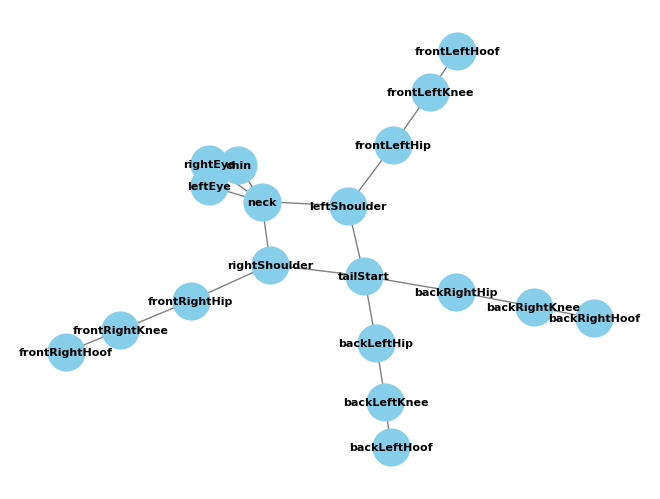

In [11]:
# Create a graph
graph_network = nx.Graph(graph)


# Draw the graph
# pos = nx.spring_layout(graph_network)  # You can choose a different layout algorithm
nx.draw(graph_network, with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

# Display the graph
plt.show()


In [12]:
# save dictionary to JSON file
with open('behavoiur-discovery/graph.json', 'w') as fp:
    json.dump(graph, fp, indent=4)

Define rules to connect the nodes
1. Load the .mat files 
2. Create a graph for each frame and a queue for each file
3. Normalize the x,y coordinates

In [25]:
# get the landmarks folder containing .mat files
landmarks_folder = os.path.join(os.getcwd(), 'landmarks\horse')

# load a file
def load_file(filename):
    # only load .mat files
    if not filename.endswith('.mat'):
        return None
    else:
        mat = scipy.io.loadmat(filename)
        return mat['landmarks']

# choose a file at random
random_landmark_file = random.choice(os.listdir(landmarks_folder))
print(random_landmark_file)
random_load = load_file(os.path.join(landmarks_folder, random_landmark_file))

647.mat


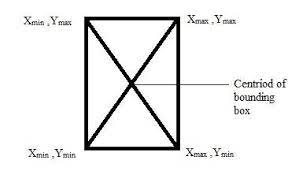

In [14]:
print(f'File shape: {random_load.shape}') # the shape indicating the number of frames 

first_frame = random_load[0][0][0] # the first frame of the first landmark
# get the positions and if present
positions = first_frame['positions'][0]

present = first_frame['present'][0]
print(f'Positions shape: {positions.shape}') # the x,y coordinates for the first frame
print(f'Present shape: {present.shape}')

# normalize the positions to be between 0 and 1
scaler = MinMaxScaler()
positions = scaler.fit_transform(positions)
positions = [np.linalg.norm([x, y]) for x, y in positions]

# create a graph if the points are present
print(dict(zip(points, present)))
print(dict(zip(points, positions)))




File shape: (63, 1)
Positions shape: (19, 2)
Present shape: (19, 1)
{'leftEye': array([0], dtype=uint8), 'rightEye': array([1], dtype=uint8), 'chin': array([1], dtype=uint8), 'frontLeftHoof': array([1], dtype=uint8), 'frontRightHoof': array([1], dtype=uint8), 'backLeftHoof': array([1], dtype=uint8), 'backRightHoof': array([1], dtype=uint8), 'tailStart': array([1], dtype=uint8), 'frontLeftKnee': array([1], dtype=uint8), 'frontRightKnee': array([1], dtype=uint8), 'backLeftKnee': array([1], dtype=uint8), 'backRightKnee': array([1], dtype=uint8), 'leftShoulder': array([0], dtype=uint8), 'rightShoulder': array([1], dtype=uint8), 'frontLeftHip': array([0], dtype=uint8), 'frontRightHip': array([1], dtype=uint8), 'backLeftHip': array([0], dtype=uint8), 'backRightHip': array([1], dtype=uint8), 'neck': array([1], dtype=uint8)}
{'leftEye': 0.0, 'rightEye': 1.092453188679702, 'chin': 1.1102806038718587, 'frontLeftHoof': 1.3125133412216334, 'frontRightHoof': 1.2282423331334613, 'backLeftHoof': 1.05

['leftEye', 'leftShoulder', 'frontLeftHip', 'backLeftHip']


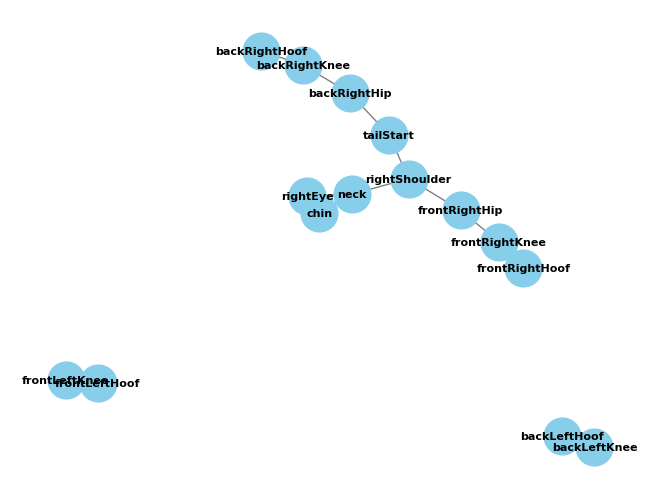

In [23]:
# absent_nodes
absent_nodes = [key for key, val  in dict(zip(points, present)).items() if val == 0]
print(absent_nodes)

# initialize graph
G = nx.Graph()

# add nodes and weighted edges
for node, neighbors in graph.items():
    for neighbor in neighbors:
        if neighbor not in absent_nodes and node not in absent_nodes:
            # get the weights
            weights = dict(zip(points, positions))[neighbor] 
            # add the weighted edges
            G.add_edge(node, neighbor, weight=weights)

# draw the graph
# pos = nx.spring_layout(G)
nx.draw(G,  with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')


In [ ]:
# landmarks directory
def landmarks_path(directory):
    landmarks_folder = os.path.join(os.getcwd(), directory)
    # get the landmarks folder to a list
    landmarks = os.listdir(landmarks_folder)
    # return the path to each file
    return [os.path.join(landmarks_folder, landmark) for landmark in landmarks if landmark.endswith('.mat')]

# load a file
def load_file(filename):
    # only load .mat files
    if filename.endswith('.mat'):
        mat = scipy.io.loadmat(filename)
        return mat['landmarks']

# a function to take in the loaded file and return a sequence of graphs
def graph_sequence(directory='landmarks\horse'):
    # load the files
    files = landmarks_path(directory)
    print(files)
    graphs_dict = dict() # A dictionary of all the files and the graphs
    # load each file
    for file in files:
        graph_list = [] # a list of graphs for each file
        # load the file
        loaded_file = load_file(file)
        print(f'Loaded file: {file}, shape: {loaded_file.shape}')
        # loop through each frame
        for frame in loaded_file[0][0]: # the first frame of the first landmark
            # get the positions and if present
            positions = frame['positions'][0]
            present = frame['present'][0]
            print(f'Positions shape: {positions.shape}') # the x,y coordinates for the first frame
            print(f'Present shape: {present.shape}')
            # normalize the positions to be between 0 and 1
            scaler = MinMaxScaler()
            positions = scaler.fit_transform(positions)
            positions = [np.linalg.norm([x, y]) for x, y in positions]

            # absent_nodes
            absent_nodes = [key for key, val  in dict(zip(points, present)).items() if val == 0]

            # initialize graph
            G = nx.Graph()

            # add nodes and weighted edges
            for node, neighbors in graph.items():
                for neighbor in neighbors:
                    if neighbor not in absent_nodes and node not in absent_nodes:
                        # get the weights
                        weights = dict(zip(points, positions))[neighbor] 
                        # add the weighted edges
                        G.add_edge(node, neighbor, weight=weights)
            # append the graph to the list
            graph_list.append(G)
        # add the file and the list of graphs to the dictionary
        # split the filename
        file2split = file.split('\\')[-1]
        graphs_dict[file2split] = graph_list
    # return the dictionary
    return graphs_dict
graph_seq = graph_sequence()



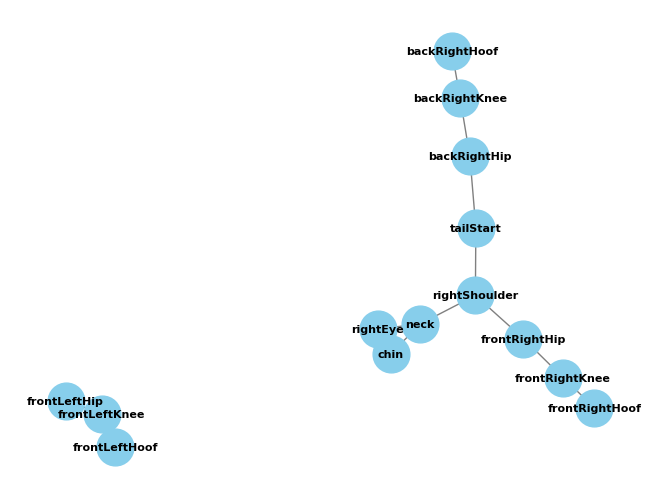

In [42]:
first_file_frame = graph_seq['647.mat'][0]
# draw the graph
# pos = nx.spring_layout(first_file_frame)
nx.draw(first_file_frame,  with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

In [43]:
nx.to_dict_of_lists(first_file_frame)

{'chin': ['rightEye', 'neck'],
 'rightEye': ['chin', 'neck'],
 'neck': ['chin', 'rightEye', 'rightShoulder'],
 'rightShoulder': ['neck', 'frontRightHip', 'tailStart'],
 'frontRightHip': ['rightShoulder', 'frontRightKnee'],
 'tailStart': ['rightShoulder', 'backRightHip'],
 'frontLeftHip': ['frontLeftKnee'],
 'frontLeftKnee': ['frontLeftHip', 'frontLeftHoof'],
 'frontRightKnee': ['frontRightHip', 'frontRightHoof'],
 'frontLeftHoof': ['frontLeftKnee'],
 'frontRightHoof': ['frontRightKnee'],
 'backRightHip': ['tailStart', 'backRightKnee'],
 'backRightKnee': ['backRightHip', 'backRightHoof'],
 'backRightHoof': ['backRightKnee']}

In [24]:
print(absent_nodes)
# get the dict from the graph
nx.to_dict_of_lists(G)

['leftEye', 'leftShoulder', 'frontLeftHip', 'backLeftHip']


{'chin': ['rightEye', 'neck'],
 'rightEye': ['chin', 'neck'],
 'neck': ['chin', 'rightEye', 'rightShoulder'],
 'rightShoulder': ['neck', 'frontRightHip', 'tailStart'],
 'frontRightHip': ['rightShoulder', 'frontRightKnee'],
 'tailStart': ['rightShoulder', 'backRightHip'],
 'frontRightKnee': ['frontRightHip', 'frontRightHoof'],
 'frontLeftKnee': ['frontLeftHoof'],
 'frontLeftHoof': ['frontLeftKnee'],
 'frontRightHoof': ['frontRightKnee'],
 'backRightHip': ['tailStart', 'backRightKnee'],
 'backRightKnee': ['backRightHip', 'backRightHoof'],
 'backLeftKnee': ['backLeftHoof'],
 'backLeftHoof': ['backLeftKnee'],
 'backRightHoof': ['backRightKnee']}

In [329]:
len(list(G.nodes))

16